In [1]:
# Run the notebook as if it's in the PROJECT directory
%bookmark PROJ_ROOT /reg/data/ana03/scratch/cwang31/pf
%cd -b PROJ_ROOT

(bookmark:PROJ_ROOT) -> /reg/data/ana03/scratch/cwang31/pf
/reg/data/ana03/scratch/cwang31/pf


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [52]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors     as mcolors
import matplotlib.transforms as mtransforms
%matplotlib inline

In [90]:
import os

In [4]:
timestamp = "2022_1101_1429_21"    # Focal loss (my imp)

## Random model

In [5]:
from peaknet.methods.unet import UNet
from peaknet.model        import ConfigPeakFinderModel, PeakFinderModel

In [8]:
base_channels = 8
focal_alpha   = 0.8
focal_gamma   = 2.0
method = UNet( in_channels   = 1,
               out_channels  = 1,
               base_channels = base_channels, )
config_peakfinder = ConfigPeakFinderModel( method = method, 
                                           focal_alpha = focal_alpha,
                                           focal_gamma = focal_gamma, )
model = PeakFinderModel(config_peakfinder)
model.init_params()

In [9]:
model.init_params(from_timestamp = timestamp)   # Run this will load a trained model

In [10]:
# Load model to gpus if available...
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
model  = torch.nn.DataParallel(model.method).to(device)

## Load a cspad panel

In [14]:
from peaknet.datasets.utils import PsanaImg

In [15]:
exp           = 'cxic0415'
## run           = 101
run           = 85
mode          = 'idx'
detector_name = 'CxiDs1.0:Cspad.0'
psana_img = PsanaImg(exp, run, mode, detector_name)

In [18]:
event = 18537
multipanel_mask       = psana_img.create_bad_pixel_mask()
multipanel_img        = psana_img.get(event, None, 'calib')
multipanel_img_masked = multipanel_mask * multipanel_img

In [19]:
multipanel_img_masked.shape

(32, 185, 388)

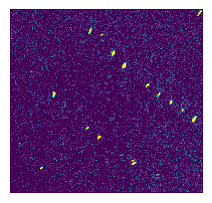

In [133]:
img = multipanel_img_masked[1][:, 388 // 2:]
# plt.figure(figsize = (14,10))
fig = plt.figure(figsize = (1.929,1.929))
vmin = img.mean()
vmax = img.mean() + 4 * img.std()
plt.imshow(img, vmin = vmin, vmax = vmax)
plt.xticks([])
plt.yticks([])
# plt.colorbar()
plt.gca().spines['top'   ].set_visible(False)
plt.gca().spines['right' ].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'  ].set_visible(False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
plt.set_cmap('viridis')

In [134]:
# Define the filename...
filename = 'Figure.predict.input'

# Set up drc...
DRCPDF         = "pdfs"
drc_cwd        = os.getcwd()
prefixpath_pdf = os.path.join(drc_cwd, DRCPDF)
if not os.path.exists(prefixpath_pdf): os.makedirs(prefixpath_pdf)

# Specify file...
fl_pdf = f"{filename}.pdf"
path_pdf = os.path.join(prefixpath_pdf, fl_pdf)

# Export...
## plt.savefig(path_pdf, dpi = 100, bbox_inches='tight', pad_inches = 0)
fig.savefig(path_pdf, dpi = 300)

### Okay, let's pass it through U-Net for segmentation

In [57]:
img = torch.tensor(img[None, None]).to(device)

In [32]:
model.eval()
with torch.no_grad():
    fmap = model.forward(img)

### Sigmoid is used to mimic probability

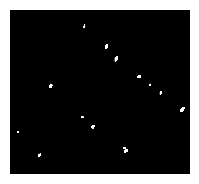

In [144]:
# plt.figure(figsize=(14,10))
fig = plt.figure(figsize=(1.792,1.792))
#data[data < 1000] = 0
segmap = fmap[0, 0].sigmoid().cpu().detach().numpy()
segmap[  segmap < 0.9 ] = 0
segmap[~(segmap < 0.9)] = 100

plt.imshow(segmap, vmin = 0, vmax = 1)
plt.xticks([])
plt.yticks([])
# plt.colorbar()
plt.gca().spines['top'   ].set_visible(False)
plt.gca().spines['right' ].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'  ].set_visible(False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
plt.set_cmap('Greys_r')

In [145]:
# Define the filename...
filename = 'Figure.predict.segmap'

# Set up drc...
DRCPDF         = "pdfs"
drc_cwd        = os.getcwd()
prefixpath_pdf = os.path.join(drc_cwd, DRCPDF)
if not os.path.exists(prefixpath_pdf): os.makedirs(prefixpath_pdf)

# Specify file...
fl_pdf = f"{filename}.pdf"
path_pdf = os.path.join(prefixpath_pdf, fl_pdf)

# Export...
## plt.savefig(path_pdf, dpi = 100, bbox_inches='tight', pad_inches = 0)
fig.savefig(path_pdf, dpi = 300)

### Label it with boxes

In [39]:
from scipy import ndimage
import matplotlib.patches as mpatches

In [41]:
# Put box on peaks...
structure = np.ones((3, 3), dtype=bool)
peak_labeled, num_peak = ndimage.label(segmap, structure)
peak_pos_list = ndimage.center_of_mass(segmap, peak_labeled, range(1, num_peak + 1))

In [42]:
len(peak_pos_list)

15

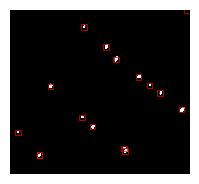

In [146]:
# fig = plt.figure(figsize=(20,15))
fig = plt.figure(figsize=(1.792,1.792))
plt.imshow(segmap, vmin = 0, vmax = 1)
# plt.colorbar()

plt.set_cmap('Greys_r')

# Add box
offset = 3
linewidth = 0.5
for y, x in peak_pos_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x - offset
    y_bottom_left = y - offset

    ## x_bottom_left += 2
    ## y_bottom_left += 1

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = linewidth, 
                                 edgecolor = 'red', 
                                 facecolor='none')
    fig.gca().add_patch(rec_obj)

fig.gca().add_patch(rec_obj)
# plt.xlim(600,1000)
# plt.ylim(150,500)
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'   ].set_visible(False)
plt.gca().spines['right' ].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'  ].set_visible(False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)


In [147]:
# Define the filename...
filename = 'Figure.predict.segmap+location'

# Set up drc...
DRCPDF         = "pdfs"
drc_cwd        = os.getcwd()
prefixpath_pdf = os.path.join(drc_cwd, DRCPDF)
if not os.path.exists(prefixpath_pdf): os.makedirs(prefixpath_pdf)

# Specify file...
fl_pdf = f"{filename}.pdf"
path_pdf = os.path.join(prefixpath_pdf, fl_pdf)

# Export...
## plt.savefig(path_pdf, dpi = 100, bbox_inches='tight', pad_inches = 0)
fig.savefig(path_pdf, dpi = 300)

In [54]:
from peaknet.datasets.transform import coord_crop_to_img, center_crop

In [58]:
# Center crop to facilitate visualization
size_y_segmap, size_x_segmap = fmap.shape[-2:]
img_crop = center_crop(img, size_y_segmap, size_x_segmap)

In [61]:
img_crop = img_crop[0, 0].cpu().detach().numpy()

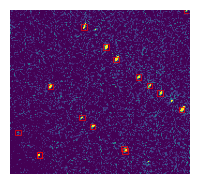

In [139]:
# fig = plt.figure(figsize=(20,15))
fig = plt.figure(figsize=(1.792,1.792))

plt.set_cmap('viridis')

vmin = img_crop.mean()
vmax = img_crop.mean() + 4 * img_crop.std()
plt.imshow(img_crop, vmin = vmin, vmax = vmax)
# plt.colorbar()

# img_handle = plt.imshow(segmap, vmin = 0, vmax = 1, alpha = 0.4)
# cmap1 = mcolors.ListedColormap(['none', 'red'])
# img_handle.set_cmap(cmap1)


# Add box
offset = 3
linewidth = 0.5
for y, x in peak_pos_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x - offset
    y_bottom_left = y - offset

    ## x_bottom_left += 2
    ## y_bottom_left += 1
    
    # y_bottom_left, x_bottom_left = coord_crop_to_img((y_bottom_left, x_bottom_left), img.shape, segmap.shape)

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = linewidth, 
                                 edgecolor = 'red', 
                                 facecolor='none', )
    fig.gca().add_patch(rec_obj)

fig.gca().add_patch(rec_obj)
# plt.xlim(600,1000)
# plt.ylim(150,500)
plt.xticks([])
plt.yticks([])
plt.gca().spines['top'   ].set_visible(False)
plt.gca().spines['right' ].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'  ].set_visible(False)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)


In [140]:
# Define the filename...
filename = 'Figure.predict.overlay'

# Set up drc...
DRCPDF         = "pdfs"
drc_cwd        = os.getcwd()
prefixpath_pdf = os.path.join(drc_cwd, DRCPDF)
if not os.path.exists(prefixpath_pdf): os.makedirs(prefixpath_pdf)

# Specify file...
fl_pdf = f"{filename}.pdf"
path_pdf = os.path.join(prefixpath_pdf, fl_pdf)

# Export...
## plt.savefig(path_pdf, dpi = 100, bbox_inches='tight', pad_inches = 0)
fig.savefig(path_pdf, dpi = 300)